# Pre-processing scRNA-seq data

Before starting the analysis, it is important to ensure that:

- no low-quality samples or measurements will negatively affect the results,

- the data have been transformed in a way that is appropriate for the analysis to perform.

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Load the data

We will analyze a single-cell RNA-seq dataset of T cells using the Scanpy package.

The dataset is stored in h5ad format and contains 5,016 cells and 20,953 genes, covering both protein-coding and non-coding genes (e.g., RP11-34P13.7, FO538757.2, MEF2B). Each cell is annotated with metadata including:

- `cell.type` (Naive, Memory, etc.)
- `cytokine.condition` (e.g., UNS)
- `donor.id` (D1–D4)
- `batch.10X` (batch information)
- Quality metrics: `nGene`, `nUMI`, `percent.mito`
- Cell cycle information: `S.Score`, `G2M.Score, Phase`
- Cluster assignment: `cluster.id`
- Functional annotation: `effectorness`

In [108]:
path = '/Users/systems/Desktop/Bioinformatics Course/Python/scRNA-seq/'
scdr = sc.read_h5ad(path + 'scdr.h5ad')
# Print initial shape: (cells, genes) or (barcodes x number of transcripts)
(scdr.n_obs, scdr.n_vars)

(5016, 20953)

In [109]:
scdr.varm

AxisArrays with keys: 

In [110]:
# Save original raw counts for later (DE, etc.)
scdr.raw = scdr.copy()   # preserves raw counts
scdr.uns['initial_shape'] = (scdr.n_obs, scdr.n_vars)

## Basic quality control

In single-cell analysis, each observation is assumed to represent measurements from one intact cell. This assumption can be violated due to low-quality cells, ambient RNA contamination, or doublets. In this section, we identify and remove these problematic observations to obtain a high-quality dataset suitable for downstream analysis.

In [111]:
# Handle both 'MT-' and 'mt-' and Ensembl fallback
mt_mask = (scdr.var_names.str.upper().str.startswith('MT-')) | (scdr.var_names.str.upper().str == 'MT')

if mt_mask.sum() == 0:
    print("No mitochondrial genes found with 'MT-' prefix. Trying Ensembl IDs...")
    
scdr.var['mat'] = mt_mask

`n_genes_by_counts` → number of genes detected in each cell

`total_counts` → total number of reads/UMIs per cell

`pct_counts_mat` → fraction of reads mapping to mitochondrial genes

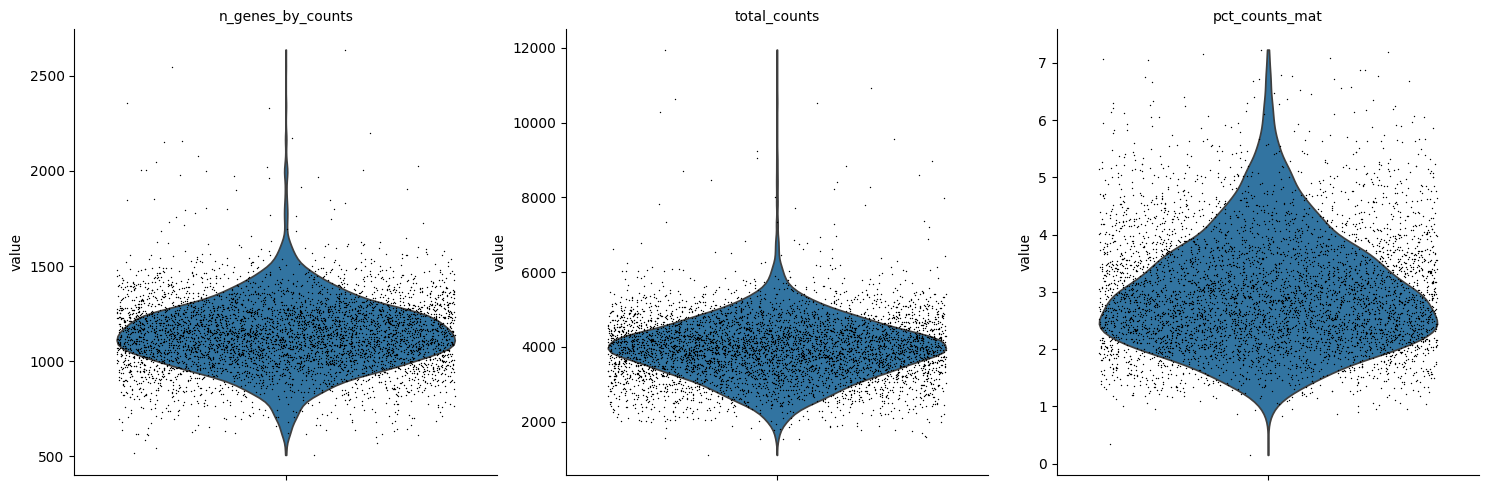

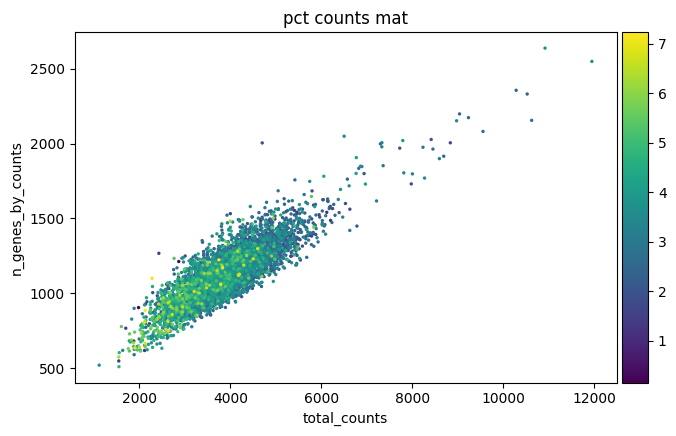

In [112]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(scdr, qc_vars=['mat'], inplace=True)

# inspect distributions (violin + scatter plots)
sc.pl.violin(scdr, ['n_genes_by_counts','total_counts','pct_counts_mat'], jitter=0.4, multi_panel=True)
sc.pl.scatter(scdr, x='total_counts', y='n_genes_by_counts', color='pct_counts_mat')

Quality control was performed to retain high-confidence single-cell transcriptomes. 

1. Cells with fewer than 200 expressed genes were excluded to remove low-complexity libraries 

2. Genes expressed in fewer than 3 cells were filtered to reduce sparsity

3. Potential doublets were removed by excluding cells with more than 2,000 detected genes 

3. Cells likely affected by ambient RNA contamination were filtered by removing those with >5% mitochondrial transcript content.


In [113]:
# filtering cells
# removing cells where fewer than 200 expressed genes
sc.pp.filter_cells(scdr, min_genes=200)
(scdr.n_obs, scdr.n_vars)

(5016, 20953)

In [114]:
# filtering genes
sc.pp.filter_genes(scdr, min_cells=3)
(scdr.n_obs, scdr.n_vars)

(5016, 14699)

In [115]:
# filtering out possible doublets
scdr = scdr[scdr.obs.n_genes_by_counts < 2000, :].copy()
print(f'After cleaning the doublets: {scdr.n_obs, scdr.n_vars}')

After cleaning the doublets: (5001, 14699)


In [116]:

# filtering out cells possibly affected by contamination
scdr = scdr[scdr.obs.pct_counts_mat < 5, :].copy()
print(f'After cleaning the contaminated cells: {scdr.n_obs, scdr.n_vars}')


After cleaning the contaminated cells: (4783, 14699)


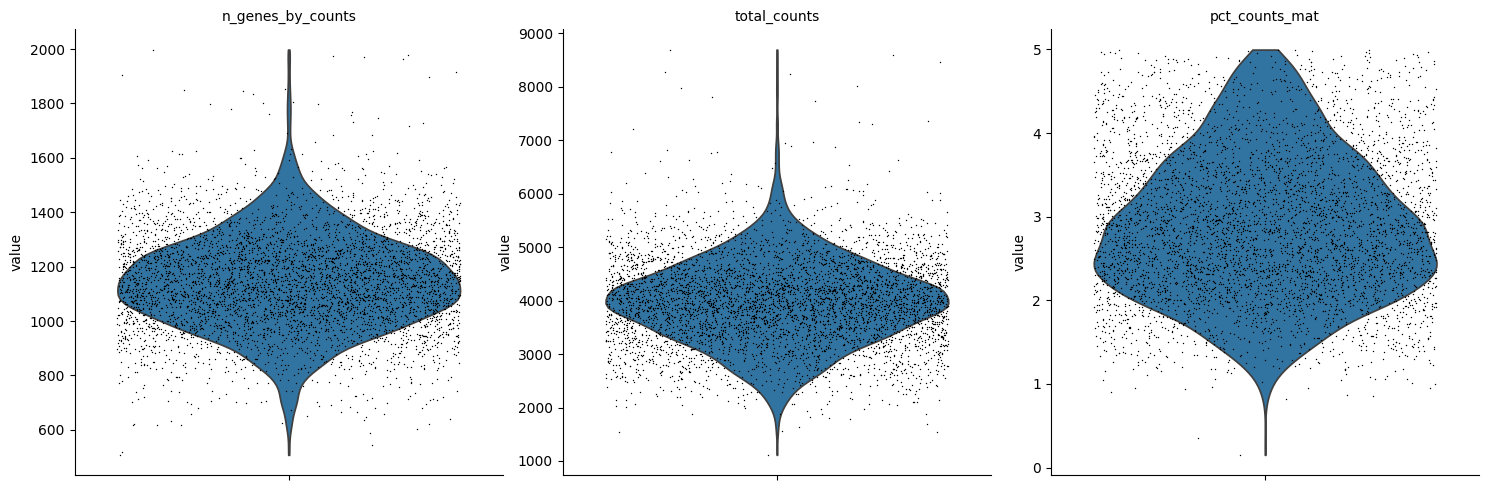

In [117]:
# plotting again the quality control violin plots
sc.pl.violin(scdr, ['n_genes_by_counts', 'total_counts', 'pct_counts_mat'],
             jitter=0.4, multi_panel=True)

The three distribution appear less skewed, and we can now assume that we discarded the most problematic samples.

Alternatives to thresholding are CellBender and Scrublet (doublet removal).

## Pre-processing pipeline

normalization

variance-stabilization transformation

regressing out confounders

scaling

### Normalization

Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.

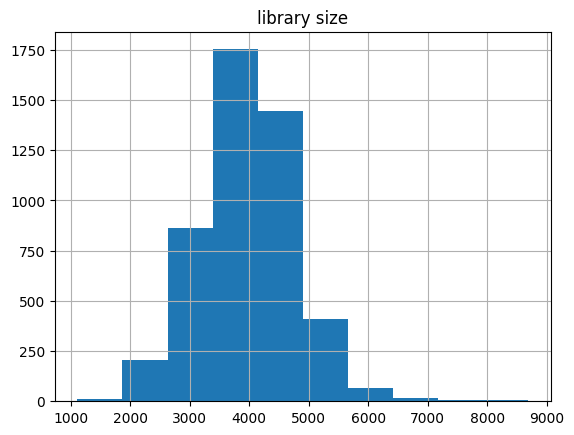

In [118]:
# Pre-normalization

# summing reads for each cell
library_size = scdr.X.sum(axis = 1)

# transforming in a pandas data frame
library_size = pd.DataFrame({'library size':np.array(library_size).flatten()}, index=scdr.obs_names)

# plotting the library size distribution
tmp = library_size.hist()

In [ ]:
# Normalization
sc.pp.normalize_total(scdr, target_sum=1e4)

# new library size
library_size = scdr.X.sum(axis = 1)
(library_size.min(), library_size.max())

(9999.998, 10000.002)

As we can see all the cell have a normalized library size equal to 10000, up to rounding error.

### variance-stabilization transformation

it makes the data numerically and statistically suitable for downstream analyses like PCA, neighborhood graph computation, and clustering.

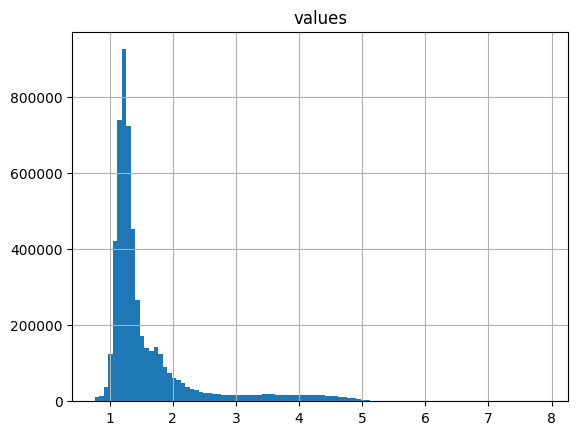

In [121]:
# log transforming the values
sc.pp.log1p(scdr)

# histogram of all values
tmp = np.array(scdr.X.todense()).flatten()
tmp = tmp[tmp > 0]
tmp = pd.DataFrame({'values': tmp}).hist(bins=100)

While still far from an optimal normal distribution, the values are now much less dispersed.

### Focus on highly variable genes (HVGs)

we will now identify the most variable genes, and we will operate from now on only on this subset. The reason behind this is that these genes are likely to retain most of the signal present in the data, while at the same time this will speed up the computations.

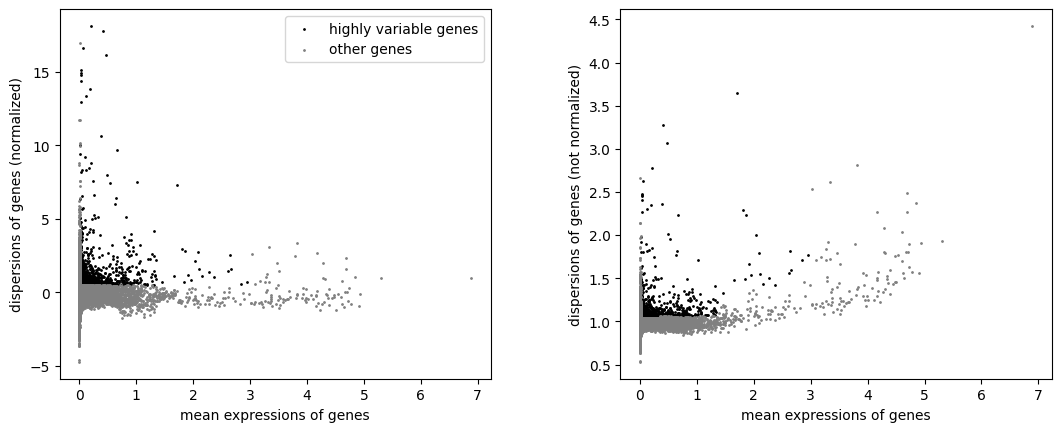

In [122]:
# identifying the genes with the highest variation
sc.pp.highly_variable_genes(scdr)
sc.pl.highly_variable_genes(scdr)

The two plots show the same information: when the mean expression of each gene is plotted against its dispersion, genes that stand out above the trend have higher-than-expected variability. These highly variable genes are the ones we focus on in downstream analyses, as they carry the most biological signal for distinguishing cell states and types.

In [123]:
# what is the percentage of highly variable genes?
print('%.1f' % np.round(scdr.var.highly_variable.sum()/scdr.n_vars * 100, 3) + '%')

10.3%


In [124]:
# current status of the data stored in "raw"
scdr.raw = scdr.copy()

#### Save the HVGs

In [127]:
# selecting only the most variable genes
scdr_hvg = scdr[:, scdr.var.highly_variable].copy()
scdr_hvg.n_vars

1517

### Scaling

Normalization by Z-score (subtraction of each gene's mean expression and divide by its standard deviation). This standardization brings all genes to a comparable scale, ensuring that no single gene dominates due to differences in expression magnitude. Scaling is a crucial preprocessing step for algorithms such as PCA, which assume that all features contribute equally to the variance structure of the data.

In [135]:
# scaling
sc.pp.scale(scdr_hvg, max_value=10)

/Users/systems/miniconda3/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


-0.0 1.0


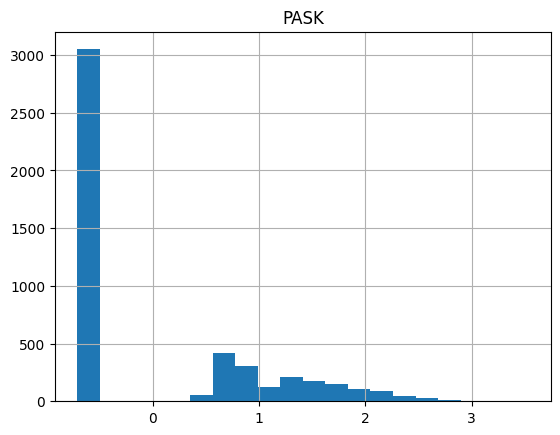

In [136]:
# Sanity check

# distribution of the PASK gene after scaling. 
tmp = pd.DataFrame({'PASK':scdr_hvg[:, 'PASK'].X.toarray().flatten()}).hist(bins=20)

# printing the average value and standard deviation of PASK
print(np.round(scdr_hvg[:, 'PASK'].X.toarray().mean()), np.round(scdr_hvg[:, 'PASK'].X.toarray().std()))

In [ ]:
# identify the top 5 highly variable genes

top_hvg = scdr_hvg.var.sort_values('highly_variable').head(5).index
print(top_hvg)


Index(['KLHL17', 'ALDH2', 'FICD', 'MTERF2', 'C12orf75'], dtype='object')


The mean of KLHL17 is -0.0,        The std of KLHL17 is 1.0
The mean of ALDH2 is -0.0,        The std of ALDH2 is 1.0
The mean of FICD is -0.0,        The std of FICD is 1.0
The mean of MTERF2 is 0.0,        The std of MTERF2 is 1.0
The mean of C12orf75 is 0.0,        The std of C12orf75 is 1.0


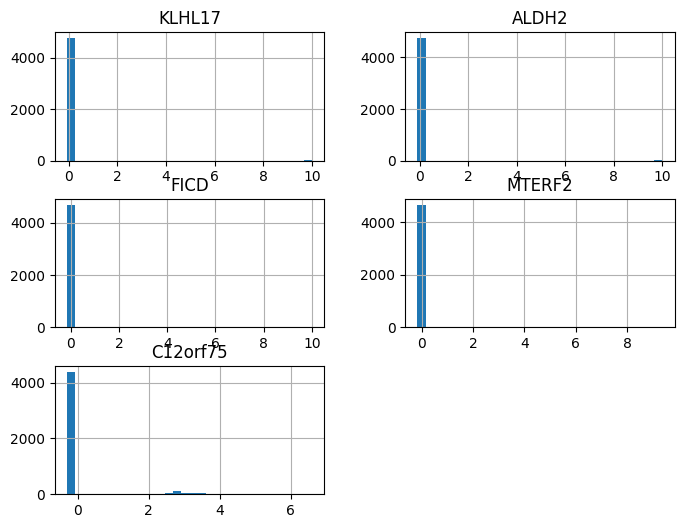

In [ ]:
# Sanity ceck

genes_to_plot = ['KLHL17', 'ALDH2', 'FICD', 'MTERF2', 'C12orf75'] 

for gene in genes_to_plot:
    print(f'The mean of {gene} is {np.round(scdr_hvg[:, gene].X.toarray().mean())},\
        The std of {gene} is {np.round(scdr_hvg[:, gene].X.toarray().std())}')

df = pd.DataFrame({
    g: scdr_hvg[:, g].X.toarray().ravel() for g in genes_to_plot
})
df.hist(bins=30, figsize=(8, 6))
plt.show()

Mean ≈ 0, standard deviation ≈ 1 after sc.pp.scale().

Confirms successful z-score standardization for a gene or subset of genes.

## Summary / Conclusion

In this notebook, we performed **preprocessing and quality control** on single-cell RNA-seq data of T cells. The main steps included:

1. **Filtering low-quality cells and genes** – Removed cells with few detected genes, high mitochondrial content, or predicted doublets.  
2. **Normalization and log transformation** – Scaled total counts per cell to a common library size (CPM) and applied `log1p` to reduce skew and compress extreme values. Histograms of expression values were used to inspect the distributions and ensure normalization behaved as expected.  
3. **Selection of highly variable genes (HVGs)** – Focused on the subset of genes carrying the most biological signal, reducing noise and computational load.  
4. **Scaling (z-score normalization)** – Standardized gene expression to mean 0 and unit variance, preparing the data for downstream analyses such as PCA, clustering, and UMAP.  
5. **Sanity checks** – Verified that normalization and scaling worked correctly for individual genes and across the dataset.

After these preprocessing steps, the dataset now consists of **high-quality cells and genes**, with expression values normalized and scaled. This ensures that subsequent analyses will reflect true biological variation rather than technical noise.
